In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

import importlib
PARENT_DIR = os.path.realpath('..')+'/'
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)
    
try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
sess = tf.Session()

In [3]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [4]:
quant = 256*256#16#M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

In [5]:
len(list(Path(DIRS['RAW_DATA']).rglob("*.wav")))

14

In [6]:
n_files = 14

In [7]:
wav_fnames = Path(DIRS['RAW_DATA']).rglob("*.wav")
Xs = []
for idx, fname in enumerate(wav_fnames):
    if idx==n_files: break
    audio = sl.load_audio_not_one_hot(fname.as_posix(), quantization_channels=quant)
    Xs.append(audio[:-1])
    
X = tf.concat(Xs,axis=0)
X = tf.reshape(X, (1,-1,1))
n = 2**(nbits//2)
X = tf.concat([X//n, X%n], 2)
X = (X-128)/128
print(X.shape)
X[0,1000:1005].eval(session=sess)

(1, 46856098, 2)


array([[ 0., -1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 0., -1.]])

In [8]:
def generate_batch(X, batch_size, truncated_len):
    idxs = random.randint(0,X.shape[1]-truncated_len-1, size=batch_size)
    x = tf.concat([X[:,idxs[i]:idxs[i]+truncated_len] for i in range(batch_size)],axis=0)
    y = tf.concat([X[:,idxs[i]+1:idxs[i]+truncated_len+1] for i in range(batch_size)],axis=0)
    return x,y

# Build model

In [9]:
class GRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t

In [10]:
# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reverved for the second term
input_dimensions = 2

# Arbitrary number for the size of the hidden state
hidden_size = 2

## V1

In [11]:
batch_size = 100
truncated_len = M_PARAMS['SAMPLE_RATE']
total_series_length = int(X.shape[1])
num_epochs = 480 #total_series_length//batch_size//truncated_len
print(batch_size, truncated_len, total_series_length, num_epochs)

100 16000 46856098 480


1 min per iteration -> 60 iters in hour => 480 iters in 8 hours

In [12]:
# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

In [13]:
output = gru.h_t
# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, truncated_len, 2), name='expected_output')
# Just use quadratic loss
loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)
# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
# Initialize all the variables
init_variables = tf.global_variables_initializer()
sess.run(init_variables)
saver = tf.train.Saver()

HBox(children=(IntProgress(value=0, max=480), HTML(value='')))

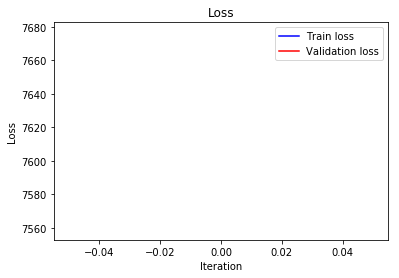

Iteration: 0, train loss: 7676.8729, test loss: 7558.6846


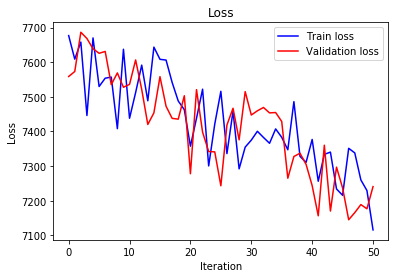

Iteration: 50, train loss: 7115.5204, test loss: 7240.6177


In [ ]:
# Initialize the losses
train_losses = []
validation_losses = []

# Perform all the iterations
for epoch in tqdm_notebook(range(num_epochs)):
    X_train, Y_train = generate_batch(X, batch_size, truncated_len)
    X_test, Y_test = generate_batch(X, batch_size, truncated_len)
    X_train, Y_train, X_test, Y_test = sess.run([X_train, Y_train, X_test, Y_test])
    
    # Compute the losses
    _, train_loss = sess.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = sess.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})
    
    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        saver.save(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_{epoch}')
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
else:
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(validation_losses, '-r', label='Validation loss')
    plt.legend(loc=0)
    plt.title('Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
    saver.save(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_last')

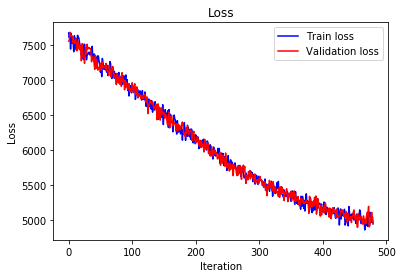

In [27]:
plt.plot(train_losses, '-b', label='Train loss')
plt.plot(validation_losses, '-r', label='Validation loss')
plt.legend(loc=0)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [92]:
saver = tf.train.Saver()

In [93]:
saver.restore(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_last')

INFO:tensorflow:Restoring parameters from /opt/jupyter/notebook/dudyrev/Speach_Synthesizer/checkpoints/DWaveRNN_v0.1_100/epoch_last


# Sound generation

In [28]:
M_PARAMS['SAMPLE_RATE']

16000

In [56]:
num_pieces = 1
generated = np.array([0,-1]*num_pieces).reshape(num_pieces,1,2)
generated

array([[[ 0, -1]]])

In [90]:
for i in tqdm_notebook(range(M_PARAMS['SAMPLE_RATE']*4)): # 1 seconds of 'speach'
    curX = generated[:,-1,:].reshape(num_pieces,-1,2)
    curY = sess.run(output, feed_dict={gru.input_layer: curX})
    generated = np.concatenate([generated, curY],axis=1)

HBox(children=(IntProgress(value=0, max=64000), HTML(value='')))

FailedPreconditionError: Attempting to use uninitialized value Wr
	 [[Node: Wr/read = Identity[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Wr)]]

Caused by op 'Wr/read', defined at:
  File "/opt/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-c020817a09dc>", line 2, in <module>
    gru = GRU(input_dimensions, hidden_size)
  File "<ipython-input-9-acd61a069765>", line 21, in __init__
    self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 80, in identity
    return gen_array_ops.identity(input, name=name)
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3264, in identity
    "Identity", input=input, name=name)
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Wr
	 [[Node: Wr/read = Identity[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Wr)]]


In [58]:
gen_to_wav = generated*128+128
gen_to_wav = np.int32((gen_to_wav[:,:,0]*256+gen_to_wav[:,:,1]).round())
gen_to_wav = tf.convert_to_tensor(gen_to_wav)

In [60]:
sl.write_audio_not_one_hot(audio=gen_to_wav[0], filename='output_0.wav', session=sess, quantization_channels=quant)

KeyboardInterrupt: 

In [70]:
gen_to_wav

<tf.Tensor 'Const_160819:0' shape=(1, 64001) dtype=int32>

In [74]:
%%time
Xs[0][:10].eval(session=sess)

CPU times: user 9min 54s, sys: 0 ns, total: 9min 54s
Wall time: 10min 10s


array([32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768,
       32768], dtype=int32)

In [75]:
# Initialize the losses
train_losses = []
validation_losses = []

# Perform all the iterations
for epoch in tqdm_notebook(range(num_epochs)):
    X_train, Y_train = generate_batch(X, batch_size, truncated_len)
    X_test, Y_test = generate_batch(X, batch_size, truncated_len)
    X_train, Y_train, X_test, Y_test = sess.run([X_train, Y_train, X_test, Y_test])
    
    # Compute the losses
    _, train_loss = sess.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = sess.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})
    
    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        saver.save(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_{epoch}')
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
else:
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(validation_losses, '-r', label='Validation loss')
    plt.legend(loc=0)
    plt.title('Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
    saver.save(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_last')

HBox(children=(IntProgress(value=0, max=480), HTML(value='')))

KeyboardInterrupt: 

## V2

In [ ]:
batch_size = 500
truncated_len = M_PARAMS['SAMPLE_RATE']
total_series_length = int(X.shape[1])
num_epochs = 500 #total_series_length//batch_size//truncated_len
print(batch_size, truncated_len, total_series_length, num_epochs)

500 16000 46856098 500


1 min per iteration -> 60 iters in hour => 480 iters in 8 hours

In [33]:
# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

In [34]:
output = gru.h_t
# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, truncated_len, 2), name='expected_output')
# Just use quadratic loss
loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)
# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer().minimize(loss)

In [35]:
# Initialize all the variables
init_variables = tf.global_variables_initializer()
sess.run(init_variables)
saver = tf.train.Saver()
last_epoch = 0

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

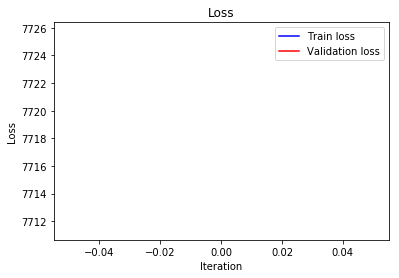

Iteration: 0, train loss: 7725.6772, test loss: 7711.3766


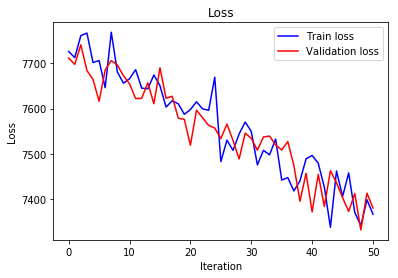

Iteration: 50, train loss: 7366.8379, test loss: 7380.6567


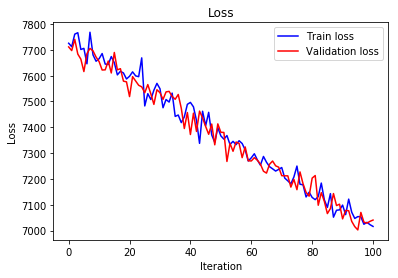

Iteration: 100, train loss: 7016.0635, test loss: 7040.7722


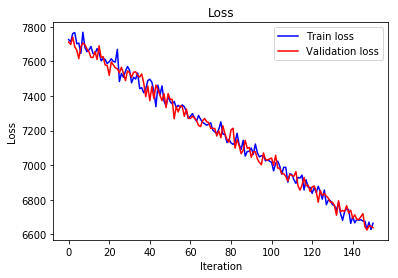

Iteration: 150, train loss: 6663.5530, test loss: 6638.1321


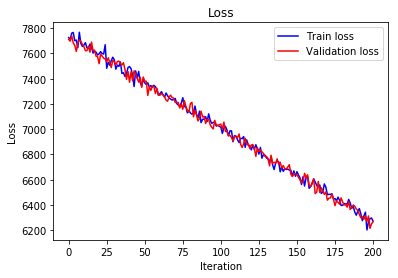

Iteration: 200, train loss: 6272.5291, test loss: 6267.0510


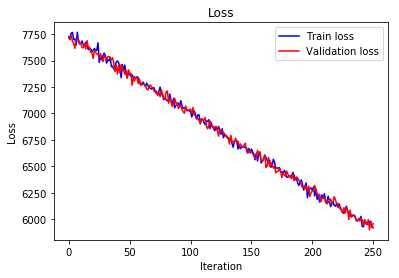

Iteration: 250, train loss: 5918.1712, test loss: 5957.5346


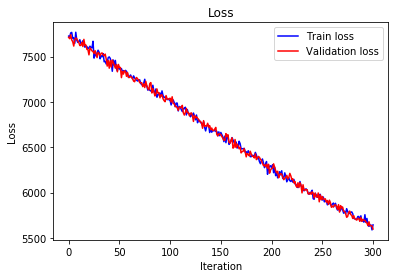

Iteration: 300, train loss: 5644.8438, test loss: 5598.7615


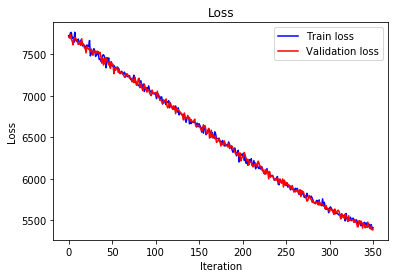

Iteration: 350, train loss: 5408.8531, test loss: 5385.1126


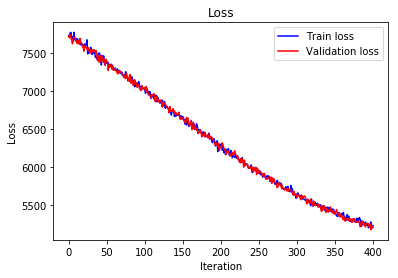

Iteration: 400, train loss: 5231.4438, test loss: 5203.9498


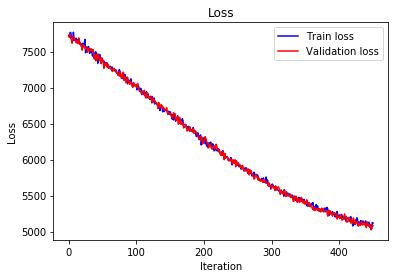

Iteration: 450, train loss: 5117.0217, test loss: 5079.2569


In [ ]:
# Initialize the losses
train_losses = []
validation_losses = []

# Perform all the iterations
for epoch in tqdm_notebook(range(last_epoch, last_epoch+num_epochs)):
    X_train, Y_train = generate_batch(X, batch_size, truncated_len)
    X_test, Y_test = generate_batch(X, batch_size, truncated_len)
    X_train, Y_train, X_test, Y_test = sess.run([X_train, Y_train, X_test, Y_test])
    
    # Compute the losses
    _, train_loss = sess.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = sess.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})
    
    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        saver.save(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_{epoch}')
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
        
else:
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(validation_losses, '-r', label='Validation loss')
    plt.legend(loc=0)
    plt.title('Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
    saver.save(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_last')

In [ ]:
plt.plot(train_losses, '-b', label='Train loss')
plt.plot(validation_losses, '-r', label='Validation loss')
plt.legend(loc=0)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [21]:
saver = tf.train.Saver()

In [22]:
saver.restore(sess, DIRS['MODEL_CKPTS']+f'DWaveRNN_v0.1_{batch_size}/epoch_last')

INFO:tensorflow:Restoring parameters from /opt/jupyter/notebook/dudyrev/Speach_Synthesizer/checkpoints/DWaveRNN_v0.1_200/epoch_last
